In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


## Preprocess

In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['thing', 'car', 'nntp_poste', 'host', 'rac_wam', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


##  Create the Dictionary and Corpus

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [10]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('wonder', 1),
  ('year', 1)]]

## Building the Topic Model

In [12]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.705*"ax" + 0.026*"graphic" + 0.013*"peace" + 0.013*"bomb" + '
  '0.012*"convert" + 0.009*"homosexual" + 0.007*"violence" + 0.006*"capture" + '
  '0.006*"birth" + 0.005*"gif"'),
 (1,
  '0.028*"people" + 0.019*"say" + 0.013*"believe" + 0.013*"reason" + '
  '0.012*"point" + 0.011*"evidence" + 0.011*"mean" + 0.011*"many" + '
  '0.011*"make" + 0.010*"state"'),
 (2,
  '0.057*"trust" + 0.049*"stupid" + 0.043*"session" + 0.032*"registration" + '
  '0.028*"conference" + 0.026*"implementation" + 0.021*"speaker" + '
  '0.021*"beautiful" + 0.018*"fish" + 0.018*"custom"'),
 (3,
  '0.092*"mail" + 0.055*"price" + 0.049*"sale" + 0.040*"cpu" + 0.036*"pin" + '
  '0.033*"disk" + 0.030*"offer" + 0.029*"tape" + 0.022*"board" + 0.021*"bus"'),
 (4,
  '0.208*"window" + 0.068*"server" + 0.062*"package" + 0.044*"motif" + '
  '0.033*"mit" + 0.028*"crash" + 0.022*"application" + 0.014*"event" + '
  '0.013*"programmer" + 0.013*"honor"'),
 (5,
  '0.058*"system" + 0.046*"use" + 0.027*"bit" + 0.025*"compute

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -13.488097326843912

Coherence Score:  0.4915515915416987


In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/timothyray/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/timothyray/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/timothyray/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/timothyray/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/timothyray/opt/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.326618 -0.134139       1        1  24.194822
1     -0.333223 -0.125185       2        1  21.307463
17    -0.285771 -0.060444       3        1  12.397923
12    -0.134102  0.078555       4        1   6.883956
5     -0.163779  0.054228       5        1   6.568507
11    -0.089428  0.385760       6        1   6.538341
0      0.061980  0.063417       7        1   4.526611
19     0.015075  0.118147       8        1   3.138699
10     0.007002 -0.035352       9        1   2.094804
7      0.057253 -0.007319      10        1   2.041686
3      0.065142 -0.025804      11        1   1.733381
18     0.038377 -0.020874      12        1   1.557127
15     0.067941 -0.000253      13        1   1.385751
13     0.067934 -0.009746      14        1   1.379848
9      0.098342  0.002402      15        1   1.221716
16     0.116849 -0.026357      16        1   1.187291
4      0.161398 -0.048280      17        1   0.728908
8      0.178899 -0.065622      18        1   0.490622
2      0.196704 -0.071213      19        1   0.334779
14     0.200026 -0.071921      20        1   0.287766, topic_info=               Term          Freq         Total Category  logprob  loglift
4435             ax  41584.000000  41584.000000  Default  30.0000  30.0000
18             line  16918.000000  16918.000000  Default  29.0000  29.0000
207           write  13232.000000  13232.000000  Default  28.0000  28.0000
143    organization  10186.000000  10186.000000  Default  27.0000  27.0000
45          article   9135.000000   9135.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
1937            usa     73.728903    267.964745  Topic20  -3.9290   4.5603
5309           vram      0.040029      1.329121  Topic20 -11.4476   2.3481
14611    vram_simms      0.040028      1.329107  Topic20 -11.4476   2.3481
14337      protocol      0.040028      1.329134  Topic20 -11.4476   2.3481
7126        encrypt      0.040028      1.329183  Topic20 -11.4476   2.3480

[846 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3348     19  0.957439      abstract
1391      8  0.998470        accept
3181     13  0.987488  access_digex
1472     16  0.992801       acquire
1554      2  0.998859           act
...     ...       ...           ...
812       9  0.992538     yesterday
628       4  0.372086         young
628       8  0.479143         young
628       9  0.147529         young
2247     14  0.994825          zone

[1117 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 18, 13, 6, 12, 1, 20, 11, 8, 4, 19, 16, 14, 10, 17, 5, 9, 3, 15])

In [15]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 9458
total tokens: 1098093
<10> LL/token: -10.16191
<20> LL/token: -9.29931
<30> LL/token: -9.02376
<40> LL/token: -8.89943

0	2.5	space research system project program launch datum cost information earth year include technology design satellite center base mission report fund 
1	2.5	line include call application package fax code software mail widget contact base offer function write support motif graphic set host 
2	2.5	drive problem speed scsi power work high line fast system switch cable pin light buy ve organization controller device ide 
3	2.5	book time find point word question reference write work water day part change note reply read mention original call scripture 
4	2.5	study drug food people school year problem doctor case find article medical health patient high eat disease day pain treatment 
5	2.5	line nntp_poste car host organization sale price buy sell good keyword mile distribution_world univ

<160> LL/token: -8.6532
<170> LL/token: -8.64791
<180> LL/token: -8.64491
<190> LL/token: -8.64248

0	2.5	space project launch cost system research earth technology design datum satellite center mission year include moon science large high base 
1	2.5	window application program software include display version image graphic package run code call support server set work widget function motif 
2	2.5	drive scsi power work problem speed ground device switch wire line high system cable pin tape light current controller ide 
3	2.5	find book time point write line give call problem organization reference question mention word read show early water original order 
4	2.5	study drug food problem effect doctor article medical health patient disease day eat result research pain treatment find report test 
5	2.5	car buy sale price line sell good bike organization engine cost cover pay mile model interested offer oil road company 
6	2.5	line organization nntp_poste write host article reply university

<310> LL/token: -8.63037
<320> LL/token: -8.6286
<330> LL/token: -8.62999
<340> LL/token: -8.62996

0	2.5	space launch system research earth datum technology project satellite design cost mission year center moon high base orbit science development 
1	2.5	window image program application display version file run software graphic server include package format support set code widget call system 
2	2.5	drive scsi work power line speed ground device problem wire system switch cable tape current make controller high ide pin 
3	2.5	time find book point write line give problem word call order mention reference organization show water original read number page 
4	2.5	drug study problem food article doctor effect medical health patient disease test eat research report people year treatment week pain 
5	2.5	car buy sale price sell good bike line organization engine cover front mile model pay offer interested road cost oil 
6	2.5	line nntp_poste organization host write article reply university d

<460> LL/token: -8.6313
<470> LL/token: -8.63134
<480> LL/token: -8.63143
<490> LL/token: -8.63002

0	2.5	space launch system earth research year project satellite technology datum cost mission high design moon center large science base orbit 
1	2.5	window image program display file version application server software graphic run include format package system color code support set widget 
2	2.5	drive scsi power line work device ground wire cable switch current system tape controller pin ide box low high connect 
3	2.5	find book time point line write problem give mention order reference organization read call number word good question show part 
4	2.5	drug study food problem effect doctor patient medical disease health article eat test research year treatment find result week case 
5	2.5	car sale buy price sell bike good ride engine line road organization speed cover mile offer drive model motorcycle front 
6	2.5	line organization nntp_poste host write article reply university distribu

<610> LL/token: -8.63233
<620> LL/token: -8.63183
<630> LL/token: -8.62883
<640> LL/token: -8.63031

0	2.5	space launch system earth project year satellite technology datum mission cost design center research moon high science large orbit flight 
1	2.5	window image program display application version file software server graphic run color include format package support system widget user code 
2	2.5	drive scsi power work ground line wire system cable switch device current high make box ide pin low type connect 
3	2.5	time find book point line write problem give read call order reference number question mention organization word good part page 
4	2.5	drug study food problem article doctor patient effect disease eat medical health report day week people find research test case 
5	2.5	car sale buy price sell bike line good ride engine speed organization road mile front cover offer drive motorcycle turn 
6	2.5	line organization nntp_poste host write article reply university distribution_wo

<760> LL/token: -8.63432
<770> LL/token: -8.63211
<780> LL/token: -8.63212
<790> LL/token: -8.63377

0	2.5	space system launch earth project datum satellite technology cost year high mission center research moon design large base orbit science 
1	2.5	window image program display application version file software server run graphic include color package format support set system widget user 
2	2.5	drive scsi power work line wire ground device high cable system current switch ide pin low box connect run make 
3	2.5	find book line time point write problem give order question read reference call number mention organization word show water original 
4	2.5	drug study food effect article doctor problem patient medical disease eat research week find day year health test report pain 
5	2.5	car sale price buy sell bike good ride line engine road speed mile organization front motorcycle model oil cover dealer 
6	2.5	line organization nntp_poste host write article reply university distribution_wor

<910> LL/token: -8.63369
<920> LL/token: -8.63577
<930> LL/token: -8.635
<940> LL/token: -8.6353

0	2.5	space launch earth system project satellite year technology datum research mission high design cost base large moon science orbit center 
1	2.5	window image program file display application version software server graphic run color include format package support set system user widget 
2	2.5	drive scsi power work line ground wire cable switch high system device current pin ide box run connect low make 
3	2.5	find line time book point write problem give read question reference number mention good call organization word order original show 
4	2.5	drug study food problem article effect doctor patient medical disease eat health test year day pain treatment report find research 
5	2.5	car sale price buy bike sell good ride engine road speed mile turn line front cover drive motorcycle dealer oil 
6	2.5	line organization nntp_poste host write article reply university distribution_world keyw

In [16]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


[(0,
  [('space', 0.025021270013148734),
   ('launch', 0.008759378142161033),
   ('earth', 0.008101941372109211),
   ('year', 0.0074058318508778715),
   ('project', 0.007367159099698353),
   ('system', 0.007367159099698353),
   ('technology', 0.006980431587903163),
   ('datum', 0.006709722329646531),
   ('satellite', 0.006690385954056771),
   ('high', 0.0063229948178513415)]),
 (4,
  [('drug', 0.010726228784150419),
   ('study', 0.008980587629082801),
   ('food', 0.008349632994721013),
   ('problem', 0.00677224640881654),
   ('doctor', 0.006519864555071824),
   ('patient', 0.006246450880181715),
   ('article', 0.006246450880181715),
   ('effect', 0.006204387237890929),
   ('report', 0.006099228132163964),
   ('disease', 0.006036132668727785)]),
 (17,
  [('write', 0.08609070372268732),
   ('article', 0.06103232909998671),
   ('good', 0.03301251020369421),
   ('thing', 0.029006966987489797),
   ('make', 0.02676690016515747),
   ('line', 0.023501718017351025),
   ('ve', 0.0218691269434478

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 9458
total tokens: 1098093
<10> LL/token: -8.99102
<20> LL/token: -8.7081
<30> LL/token: -8.62991
<40> LL/token: -8.59902

0	25	ax line organization write nntp_poste host article system run problem good window drive bit work game file car mail reply 
1	25	people write make time article thing give question good find year point day state call key work case government line 

<50> LL/token: -8.58201
<60> LL/token: -8.57135
<70> LL/token: -8.56446
<80> LL/token: -8.55885
<90> LL/token: -8.55498

0	25	ax line organization nntp_poste host write system article run file window drive problem good bit work program game mail car 
1	25	people write make article time thing give good year question line find point day state work key call case government 

<100> LL/token: -8.55289
<110> LL/token: -8.55072
<120> LL/token: -8.54856
<130> LL/token: -8.5481
<140> LL/token: -8.5471

0	25	ax line organization nntp_poste host write syst

<60> LL/token: -8.7
<70> LL/token: -8.68439
<80> LL/token: -8.67345
<90> LL/token: -8.66694

0	6.25	people state gun kill government time make happen child armenian live country woman give call fire leave law start day 
1	6.25	line key game year good organization write team nntp_poste play host article make win player time point give encryption run 
2	6.25	article write line organization nntp_poste car host good thing ve time back buy reply lot bike make hear day light 
3	6.25	file window mail run image include system software line version find program application code list display server user email internet 
4	6.25	line problem drive write bit system work host card organization nntp_poste driver file disk read chip speed fast scsi memory 
5	6.25	ax line organization max reply _ nntp_poste version_pl tm qax air part sc ss au rlk sp ei mp georgia_institute 
6	6.25	space system work year information technology service research group make provide public cost government issue money program

<410> LL/token: -8.63445
<420> LL/token: -8.6338
<430> LL/token: -8.63448
<440> LL/token: -8.63468

0	6.25	people state gun kill write article government time make happen armenian live law child country call start attack fire day 
1	6.25	line write organization article year good nntp_poste game host team play win player make point time run give hit university 
2	6.25	article write line organization car good time ve thing nntp_poste make back bike lot light day buy host turn power 
3	6.25	file window program mail include information image version send code software list run line application source internet system user email 
4	6.25	line nntp_poste problem drive organization host write bit system card work driver sale computer chip run scsi disk price speed 
5	6.25	ax line organization max _ reply qax air tm sc part sp au forsale rlk ei purdue_university reserve_university ss pl 
6	6.25	key system space work year make government technology service public information provide encryption re

<760> LL/token: -8.62595
<770> LL/token: -8.62712
<780> LL/token: -8.62832
<790> LL/token: -8.63004

0	6.25	people state gun kill write article time government armenian happen make live law child give country fire attack start leave 
1	6.25	line write organization article year good game nntp_poste team host play win player make time point run give hit start 
2	6.25	article write car line good organization thing ve time make lot bike light back day turn long problem ground ride 
3	6.25	file window program line include mail image send version information code list software application run set internet user email source 
4	6.25	line organization nntp_poste host drive write problem system work bit card driver computer article sale buy run price reply disk 
5	6.25	ax organization line max reply _ qax tm air sc au sp rlk ei part ss mp lk pl rk 
6	6.25	key system space make work government information technology service year public encryption group provide research time money program organiza

<110> LL/token: -8.65043
<120> LL/token: -8.64186
<130> LL/token: -8.63358
<140> LL/token: -8.62962

0	3.57143	word question people christian claim exist true life religion make argument truth church man faith evidence follow reason answer book 
1	3.57143	line study case entry write year find drug info food read effect problem test article rule doctor number report time 
2	3.57143	game year team play player win line good run season hit fan goal lose point hockey time score pick baseball 
3	3.57143	people state gun government law kill country force article war attack crime israeli weapon fact case write action land live 
4	3.57143	make work group technology issue year provide government program question address state support bill plan business include order privacy public 
5	3.57143	car time back model high power engine good big water buy small point side turn speed long find change mile 
6	3.57143	drive problem card line work driver system bit buy scsi disk computer price monitor memor

<360> LL/token: -8.60292
<370> LL/token: -8.60206
<380> LL/token: -8.60006
<390> LL/token: -8.60075

0	3.57143	word question christian people claim exist life religion true argument truth church evidence faith man book point world reason belief 
1	3.57143	line study case entry drug write year food find info report problem effect long time read test result research number 
2	3.57143	game year team play player good win line run season hit fan lose goal point hockey time give score baseball 
3	3.57143	state gun people government law country kill crime case israeli weapon war force article fact firearm person attack action citizen 
4	3.57143	year make work technology money government pay group program support state job provide issue bill plan question today include service 
5	3.57143	car buy good bike light back ride turn engine power side water time speed drive big leave mile high front 
6	3.57143	drive problem card system line work driver bit run sale computer scsi disk monitor memory ma

<610> LL/token: -8.5988
<620> LL/token: -8.60121
<630> LL/token: -8.60124
<640> LL/token: -8.60042

0	3.57143	word question christian claim people exist life true religion man church argument truth evidence faith book answer make follow fact 
1	3.57143	line case study drug entry write read problem food info year result find effect time test number research doctor day 
2	3.57143	game team year play player win good line run season hit fan lose goal hockey point score baseball give pick 
3	3.57143	gun state people law government article kill country crime case israeli weapon war force firearm make write fact person power 
4	3.57143	year work make money pay group program day job support state service plan national business issue school include cost free 
5	3.57143	car buy bike good back ride line turn drive engine water speed light side price front sell leave mile big 
6	3.57143	drive problem card system work bit line driver run computer scsi disk sale memory monitor machine video fast win

<860> LL/token: -8.60157
<870> LL/token: -8.60338
<880> LL/token: -8.60324
<890> LL/token: -8.60302

0	3.57143	question christian word claim exist people true religion life argument man church truth make faith book fact evidence belief follow 
1	3.57143	line study case entry write year drug info find food number effect result science test read research doctor report long 
2	3.57143	game year team play player win good line run season hit fan point lose goal hockey give time score great 
3	3.57143	state gun people law government article case crime country kill israeli weapon write fact firearm person war make attack force 
4	3.57143	year work make money pay program service day job support group cost time include give plan week issue free bill 
5	3.57143	car buy bike line good back ride article turn engine drive water price light speed big front road organization mile 
6	3.57143	drive problem card system work bit driver computer run line disk scsi sale monitor memory fast machine speed vi

<60> LL/token: -8.77971
<70> LL/token: -8.75307
<80> LL/token: -8.73211
<90> LL/token: -8.71981

0	2.5	key system information encryption chip technology bit security public message government privacy phone provide communication clipper part standard computer secure 
1	2.5	question claim christian exist evidence reason religion argument true thing people faith science make belief statement atheist truth assume answer 
2	2.5	gun space year launch firearm weapon project research earth system design high satellite rate mission study moon datum orbit cost 
3	2.5	state law government people make support country issue case group public question crime member free american vote citizen talk court 
4	2.5	write article line organization bike nntp_poste ride reply host post engineering wrong motorcycle black white dod battery leave stuff nice 
5	2.5	mail window send list post email address sale internet line include application information offer call group message fax question phone 
6	2.5	ax max 

<210> LL/token: -8.65556
<220> LL/token: -8.65307
<230> LL/token: -8.65118
<240> LL/token: -8.6477

0	2.5	key system encryption bit chip security technology information public government message standard privacy phone clipper provide part secure datum communication 
1	2.5	question claim exist true reason evidence religion argument make thing point science answer belief people truth assume atheist statement matter 
2	2.5	gun space year launch firearm research earth system rate high satellite project large center mission design moon datum cost orbit 
3	2.5	law state government people make support public issue case group country bill work crime vote year question free president job 
4	2.5	write article line organization bike ride reply nntp_poste leave motorcycle dog dod friend thing white wrong put cop fast stuff 
5	2.5	mail post send list email internet address group information line include sale interested computer message offer info fax service phone 
6	2.5	ax max qax tm au ei mp wm_w

<360> LL/token: -8.63195
<370> LL/token: -8.63121
<380> LL/token: -8.63035
<390> LL/token: -8.62994

0	2.5	key system encryption government chip technology bit public security information message privacy part clipper standard phone communication secure provide datum 
1	2.5	question claim exist reason true argument religion evidence point answer science matter make thing truth belief statement atheist assume wrong 
2	2.5	space system year launch project earth research datum cost high satellite program mission technology design rate base moon center orbit 
3	2.5	gun state law government people make work crime weapon public support bill firearm issue country case year group money police 
4	2.5	write line article organization bike ride nntp_poste reply turn motorcycle leave friend dog black dod thing large opinion keyword previous 
5	2.5	mail post send list information group address email internet line sale computer include interested message offer service phone question newsgroup 
6	2.5	a

<510> LL/token: -8.62601
<520> LL/token: -8.62563
<530> LL/token: -8.62797
<540> LL/token: -8.62832

0	2.5	key system encryption bit chip government public technology security information message phone privacy part clipper standard secure communication provide datum 
1	2.5	question claim exist reason true argument point make evidence thing people religion science answer assume atheist statement truth base agree 
2	2.5	space system launch year earth project cost research satellite technology datum program mission design high moon base center orbit development 
3	2.5	gun state law people government make work crime weapon public firearm bill support case job year country issue police money 
4	2.5	write article line organization bike ride reply motorcycle leave dog dod friend opinion nntp_poste large keyword turn disclaimer previous flame 
5	2.5	mail post send list information group internet email address include computer message interested line service sale newsgroup offer phone question 

<660> LL/token: -8.62943
<670> LL/token: -8.63087
<680> LL/token: -8.63081
<690> LL/token: -8.62854

0	2.5	key system encryption bit government chip technology security public message information privacy phone part clipper secure communication standard provide secret 
1	2.5	question exist claim reason true argument point evidence make thing answer science atheist statement assume write agree matter explain truth 
2	2.5	space system year launch project earth cost program satellite datum research base design mission technology moon high science orbit work 
3	2.5	gun state law people government make crime work weapon public firearm country support year money case bill issue job police 
4	2.5	write article line organization bike ride leave nntp_poste reply opinion motorcycle dog friend dod disclaimer ill large flame advice turn 
5	2.5	mail post send list information group internet address email include computer interested message service line newsgroup phone book news question 
6	2.5	ax ma

<810> LL/token: -8.63025
<820> LL/token: -8.63007
<830> LL/token: -8.63302
<840> LL/token: -8.63095

0	2.5	key system encryption bit chip public security government technology message information phone privacy part clipper standard secure communication secret datum 
1	2.5	question exist true claim reason argument point make evidence thing assume science answer atheist statement truth agree explain matter article 
2	2.5	space system launch project year earth cost research satellite datum base high mission program design technology work center moon large 
3	2.5	gun state law people government make work crime year public weapon firearm support money case bill country job issue pay 
4	2.5	write line article organization bike ride nntp_poste reply opinion friend turn motorcycle dog leave dod day large keyword big disclaimer 
5	2.5	mail post send information list address internet group email include message interested computer service newsgroup phone news number network book 
6	2.5	ax max qa

<960> LL/token: -8.62934
<970> LL/token: -8.6296
<980> LL/token: -8.62843
<990> LL/token: -8.62732

0	2.5	key system encryption bit government chip technology security public phone message privacy clipper part information standard secure communication datum provide 
1	2.5	question exist true reason claim point argument evidence science answer write make assume thing atheist statement truth word agree explain 
2	2.5	space system year launch project earth datum cost program satellite research technology mission base moon design time orbit center high 
3	2.5	gun state law people government make crime weapon year firearm money work support public country bill police job pay president 
4	2.5	write article line organization bike ride reply friend opinion motorcycle nntp_poste large dog dod disclaimer side turn hard leave flame 
5	2.5	mail post send information list group internet address email include message computer interested service book newsgroup news question network faq 
6	2.5	ax max 

<110> LL/token: -8.71074
<120> LL/token: -8.70345
<130> LL/token: -8.69753
<140> LL/token: -8.69297

0	1.92308	science make thing idea find system book write problem good theory result time world work objective real knowledge scientific difference 
1	1.92308	question claim true exist reason argument people evidence answer truth word atheist thing statement make belief point wrong matter human 
2	1.92308	good ve line ride back write road side leave time turn cover oil computer_science great ill organization thing motorcycle friend 
3	1.92308	people make thing good bad time ve happen job start put talk give day kind hope lot point kid guess 
4	1.92308	post group mail read internet service address send message email list news newsgroup question information posting net network discussion reply 
5	1.92308	space earth project satellite system mission moon research datum orbit high center power water base flight rocket technology low service 
6	1.92308	game team play year player win season go

<260> LL/token: -8.66091
<270> LL/token: -8.65789
<280> LL/token: -8.65599
<290> LL/token: -8.65561

0	1.92308	book science write find system idea problem make theory good world result thing difference objective sort scientific knowledge explain time 
1	1.92308	question true claim exist people argument reason evidence make human point truth statement atheist answer word assume belief moral wrong 
2	1.92308	good line back ride ve cover leave organization time ill great long mark miss face turn oil hear friend hard 
3	1.92308	people thing make good bad happen ve write start talk time point put day hear fire remember hope kid feel 
4	1.92308	post mail group send list address internet email message question read service information newsgroup network net news reply posting interested 
5	1.92308	space launch earth satellite mission project system moon research datum orbit center water technology flight rocket high power design fly 
6	1.92308	game team play year player win season good fan hoc

<410> LL/token: -8.65321
<420> LL/token: -8.652
<430> LL/token: -8.65348
<440> LL/token: -8.65222

0	1.92308	book science write system theory idea make find result good show thing knowledge world difference problem work real time objective 
1	1.92308	question true exist claim reason argument people evidence human make answer truth point statement atheist word moral belief agree assume 
2	1.92308	line good back organization time leave cover turn make ill face great friend mark oil side day black copy long 
3	1.92308	people make thing bad good happen ve write start hear time put day talk point fire feel remember kid guess 
4	1.92308	post mail group send list address internet message email question information network service read newsgroup posting news receive reply net 
5	1.92308	space launch earth satellite system mission moon datum project orbit center technology high research design flight rocket power water year 
6	1.92308	game team play year player win season good fan hit hockey ru

<560> LL/token: -8.6453
<570> LL/token: -8.64512
<580> LL/token: -8.64536
<590> LL/token: -8.64466

0	1.92308	book science system find write theory time make result idea work problem good scientific knowledge objective thing world learn sort 
1	1.92308	question exist true claim argument people reason evidence human make statement answer atheist truth point moral belief word assume agree 
2	1.92308	line good day leave back long time organization cover ill mark great miss call friend black ve copy week side 
3	1.92308	people make thing good bad happen write hear start time ve point fire put remember talk guess feel hope kid 
4	1.92308	post mail send group list address internet message information email question service network newsgroup read posting news receive user usenet 
5	1.92308	space launch earth satellite system research mission project moon datum orbit high technology year rocket flight center design base water 
6	1.92308	game team play year player win season good fan hit hockey

<710> LL/token: -8.64357
<720> LL/token: -8.64591
<730> LL/token: -8.64708
<740> LL/token: -8.64552

0	1.92308	book system science write theory find idea time thing result work moral case knowledge objective part learn good make scientific 
1	1.92308	question true exist claim reason people argument make evidence point human answer truth atheist statement belief religion word agree thing 
2	1.92308	good line day time leave call great ill cover back mark organization miss long make black week copy white man 
3	1.92308	people make thing bad happen write good start talk hear point fire ve put day time remember hope kid feel 
4	1.92308	post mail send group list address information internet message email question network service newsgroup posting news faq read user receive 
5	1.92308	space launch earth satellite mission system project technology research moon orbit center datum year high flight water rocket design base 
6	1.92308	game team play year player win season good fan hockey hit run 

<860> LL/token: -8.64609
<870> LL/token: -8.64536
<880> LL/token: -8.64126
<890> LL/token: -8.64306

0	1.92308	book science system theory moral make write result idea time thing work find give objective knowledge scientific study learn good 
1	1.92308	question true claim exist argument people evidence reason answer make statement atheist truth point agree belief human religion life word 
2	1.92308	line good day call time back cover long great ill make miss black mark leave week organization big white copy 
3	1.92308	people make thing happen write bad start good fire hear talk day point kid remember time hell child hope put 
4	1.92308	post mail send list group information internet address message email network service newsgroup question news faq posting user receive request 
5	1.92308	space launch earth satellite year mission moon high technology system research project datum orbit water design center flight rocket build 
6	1.92308	game team play year player win season fan good hit hock

Mallet LDA: 32 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 9458
total tokens: 1098093
<10> LL/token: -10.18198
<20> LL/token: -9.34074
<30> LL/token: -9.0732
<40> LL/token: -8.95209

0	1.5625	key datum system encryption bit chip security information clipper public message part secure mission standard block develop agency provide communication 
1	1.5625	sell price technology sale phone company cost computer system product offer pay cheap buy market line order mail interested include 
2	1.5625	space year launch project research report earth satellite moon low insurance fund cost orbit high increase service flight development program 
3	1.5625	attack write article war state israeli military weapon criminal control fight peace kill arm give area civilian country stop time 
4	1.5625	window application version run software server program display set package user include support graphic widget call system base motif mit 
5	1.5625	gun drug crime people firearm rate make kil

<110> LL/token: -8.73679
<120> LL/token: -8.72522
<130> LL/token: -8.7167
<140> LL/token: -8.71031

0	1.5625	key encryption system chip bit datum security technology public clipper message secure information communication government privacy standard secret device block 
1	1.5625	price sell sale buy company cost computer phone include technology offer pay product mail cheap market interested model order line 
2	1.5625	space launch earth research satellite system mission project moon year design center orbit flight cost high rocket development program base 
3	1.5625	israeli war attack state military kill land call give peace stop control country write arab action civilian force fight time 
4	1.5625	window application run server version software display graphic program support set package widget system include user code motif call work 
5	1.5625	gun drug crime firearm weapon rate kill criminal people death public make handgun shoot carry cop year safety ban police 
6	1.5625	church man chr

<210> LL/token: -8.68386
<220> LL/token: -8.68544
<230> LL/token: -8.67957
<240> LL/token: -8.67833

0	1.5625	key encryption chip system bit security technology clipper public secure datum government standard privacy information communication message secret phone device 
1	1.5625	price sell sale buy cost computer company pay offer include cheap mail phone software product market interested order purchase money 
2	1.5625	space launch earth datum satellite system mission research moon project orbit design high technology flight center science year rocket cost 
3	1.5625	israeli attack war give military kill leave peace state call land force time control stop country arab civilian area action 
4	1.5625	window application display graphic server run program version software set support widget code package user motif include screen function work 
5	1.5625	gun crime drug weapon firearm rate people kill criminal number death cop handgun police safety make shoot ban carry year 
6	1.5625	christia

<310> LL/token: -8.66621
<320> LL/token: -8.66427
<330> LL/token: -8.66415
<340> LL/token: -8.66414

0	1.5625	key encryption chip system bit security government technology clipper public secure information datum privacy message communication phone secret part standard 
1	1.5625	price sell sale buy cost offer pay computer company cheap include mail software line order interested phone product market purchase 
2	1.5625	space launch earth datum satellite mission system moon project research orbit year flight design technology science high rocket base large 
3	1.5625	israeli attack war state military land give peace leave call stop kill arab country force time civilian control side agree 
4	1.5625	window application run server graphic display program version support software set package widget code motif user include screen work function 
5	1.5625	gun crime weapon drug firearm kill people criminal rate number police make shoot cop handgun carry death safety ban case 
6	1.5625	christian chu

<410> LL/token: -8.65458
<420> LL/token: -8.65487
<430> LL/token: -8.65442
<440> LL/token: -8.65284

0	1.5625	key encryption chip system bit security technology clipper government public secure information privacy datum standard communication message phone access secret 
1	1.5625	price sell sale buy cost computer include offer company pay cheap software mail line product interested purchase phone market keyboard 
2	1.5625	space launch earth datum satellite mission project moon research orbit system year design technology flight high center rocket large science 
3	1.5625	israeli war attack state peace give land military kill leave call arab jewish side force center civilian stop control live 
4	1.5625	window application run display program server version graphic support package set software widget include code motif screen user work function 
5	1.5625	gun crime weapon drug firearm kill criminal rate number police make handgun carry cop death shoot safety people ban safe 
6	1.5625	christ

<510> LL/token: -8.65213
<520> LL/token: -8.65268
<530> LL/token: -8.65332
<540> LL/token: -8.6501

0	1.5625	key encryption chip system security bit government clipper public technology secure phone datum privacy information message communication device secret standard 
1	1.5625	price sell sale buy computer include offer cost company cheap software pay mail product interested line purchase order sound box 
2	1.5625	space launch earth datum satellite mission year project moon orbit research design flight technology high science rocket large center system 
3	1.5625	israeli war attack state land give peace center call leave jewish military kill arab people force stop civilian country time 
4	1.5625	window run application display program server graphic version set software support package widget code motif screen include user image color 
5	1.5625	gun crime weapon drug firearm kill carry criminal rate cop handgun death shoot make police people year safety number public 
6	1.5625	christian 

<610> LL/token: -8.64866
<620> LL/token: -8.64887
<630> LL/token: -8.64725
<640> LL/token: -8.64853

0	1.5625	key encryption system bit chip security government technology clipper public information secure datum privacy message phone communication device secret access 
1	1.5625	price sell sale buy include cost offer cheap computer company pay mail software purchase product sound interested model phone keyboard 
2	1.5625	space launch earth satellite datum mission project moon orbit year system flight science high technology research design rocket center commercial 
3	1.5625	israeli war attack state peace jewish land call center give military arab leave live force civilian kill stop country opinion 
4	1.5625	window display application run graphic server version program set support widget include package software screen code motif user image datum 
5	1.5625	gun weapon crime firearm drug kill rate criminal carry police cop handgun people death number shoot make safety year ban 
6	1.5625	ch

<710> LL/token: -8.64753
<720> LL/token: -8.64747
<730> LL/token: -8.64738
<740> LL/token: -8.64594

0	1.5625	key encryption system chip bit security government clipper technology public secure information datum message privacy phone standard communication secret access 
1	1.5625	price sell sale buy computer line include offer company cost software cheap mail pay product order interested purchase keyboard phone 
2	1.5625	space launch earth datum satellite mission project moon orbit research flight high technology system design rocket year science commercial development 
3	1.5625	israeli war attack state center land peace jewish give military country arab leave people call kill civilian force write stop 
4	1.5625	window application run display server graphic program version set support package widget include code image motif software screen user color 
5	1.5625	gun crime weapon firearm drug kill criminal rate make shoot people handgun cop number carry state safety police high year 
6	1.

<810> LL/token: -8.64895
<820> LL/token: -8.64897
<830> LL/token: -8.64653
<840> LL/token: -8.64606

0	1.5625	key encryption chip system bit security government technology clipper public datum secure information message privacy communication standard secret phone access 
1	1.5625	price sell sale buy include offer mail cost company computer cheap pay software interested line product phone purchase keyboard order 
2	1.5625	space launch earth satellite datum mission moon project orbit research year flight technology system rocket science design high development cost 
3	1.5625	israeli war attack state peace center land jewish call leave give military kill arab people force civilian stop live time 
4	1.5625	window application program display run server graphic version set image support widget package software include code screen motif user color 
5	1.5625	gun weapon crime drug firearm kill criminal rate carry cop handgun people shoot police safety state number city death ban 
6	1.5625	chris

<910> LL/token: -8.6455
<920> LL/token: -8.64473
<930> LL/token: -8.64448
<940> LL/token: -8.6454

0	1.5625	key encryption system chip bit security government technology clipper public secure information phone privacy message datum standard communication secret device 
1	1.5625	price sell sale buy offer include cost line company computer cheap software mail pay interested product keyboard sound order purchase 
2	1.5625	space launch earth satellite datum mission moon system orbit project research year flight technology rocket design science base center cost 
3	1.5625	israeli war attack state peace land jewish kill center give people call leave arab military country live world civilian opinion 
4	1.5625	window display run program application server graphic version set software support widget package image include code screen motif user call 
5	1.5625	gun crime weapon firearm drug kill criminal carry rate shoot handgun cop police people make death safety city safe gun_control 
6	1.5625	ch

Mallet LDA: 38 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 9458
total tokens: 1098093
<10> LL/token: -10.25143
<20> LL/token: -9.37501
<30> LL/token: -9.10506
<40> LL/token: -8.98044

0	1.31579	gun law crime weapon state firearm criminal police case carry make public bill court legal handgun kill person federal safety 
1	1.31579	good write line article make lot find guy organization thing call miss long pretty hear ve hand hole wave short 
2	1.31579	people government country society thing sex person world system political free homosexual community create make party minority care support gay 
3	1.31579	line entry program return read number build rule date write bit orbit follow section info title send output source long 
4	1.31579	key encryption bit chip government system technology security clipper public secure phone communication secret device privacy datum agency access standard 
5	1.31579	people day time leave happen start woman home doctor live kill call body 

<110> LL/token: -8.7604
<120> LL/token: -8.75102
<130> LL/token: -8.74641
<140> LL/token: -8.73748

0	1.31579	gun law crime weapon firearm state police criminal rate carry case cop kill handgun public court ban illegal bill death 
1	1.31579	good thing ve write lot bad make pretty real time hear stuff guy long guess article idea turn put sort 
2	1.31579	people government country society free freedom make power person support private political homosexual world party opinion state reason force social 
3	1.31579	line program file entry number read follow build section rule bit return write info date open include source output define 
4	1.31579	key encryption chip government security bit technology system clipper secure public phone privacy communication secret information datum protect block standard 
5	1.31579	people time leave start kill woman home live happen call day night back find hand remember bring put turn dead 
6	1.31579	post mail group message internet send address network newsg

<210> LL/token: -8.70572
<220> LL/token: -8.70251
<230> LL/token: -8.70056
<240> LL/token: -8.69957

0	1.31579	gun law crime state weapon firearm police criminal rate court case kill carry handgun federal ban cop safety death legal 
1	1.31579	good thing ve lot time make bad pretty give hear long great real guess stuff hard find guy idea read 
2	1.31579	people government country society free freedom make state power support person private social political opinion insurance nation homosexual reason law 
3	1.31579	line file program entry read follow number build bit return section rule info date include write title author output define 
4	1.31579	key encryption chip security bit system government public technology clipper secure phone privacy secret message communication datum information standard block 
5	1.31579	people leave time start happen live day home call kill woman hear hand back find night beat talk turn face 
6	1.31579	post mail group internet send message address list email ne

<310> LL/token: -8.68934
<320> LL/token: -8.68889
<330> LL/token: -8.68944
<340> LL/token: -8.68924

0	1.31579	gun law crime weapon state firearm police criminal case carry kill court rate handgun public ban legal cop federal bill 
1	1.31579	good thing ve make lot bad time pretty hear long great real stuff give hard find remember guess end read 
2	1.31579	people government country free society freedom make power state private support force interest political opinion person law social american world 
3	1.31579	file line program entry read build follow number info bit return section rule date open include title write source long 
4	1.31579	key encryption security chip bit government system public clipper technology secure phone message privacy secret information device standard datum encrypt 
5	1.31579	people time leave start happen home day call live kill back woman night hear hand beat stand sit put bring 
6	1.31579	post mail send internet group address list message email network newsg

<410> LL/token: -8.68623
<420> LL/token: -8.68881
<430> LL/token: -8.68974
<440> LL/token: -8.68757

0	1.31579	gun law crime weapon firearm state police criminal case carry court kill rate handgun person cop death ban arm public 
1	1.31579	good thing ve make lot bad time pretty hear guess real great stuff long hard find give remember put nice 
2	1.31579	people government make power free state freedom country private society support political person force reason public interest american opinion pay 
3	1.31579	file line entry program read bit number build info return follow rule include date source section output send open write 
4	1.31579	key encryption security chip bit government system clipper public technology secure privacy message phone secret communication standard information device encrypt 
5	1.31579	people leave time happen start live home kill call day woman hear hand night back face turn head find remember 
6	1.31579	post mail group internet address send list message email n

<510> LL/token: -8.68736
<520> LL/token: -8.68881
<530> LL/token: -8.68739
<540> LL/token: -8.68887

0	1.31579	gun law crime weapon state firearm criminal police kill carry case rate court person handgun legal bill cop death ban 
1	1.31579	good thing ve make bad lot time pretty hear great real stuff remember guess hard put find give nice sound 
2	1.31579	government people state free power make freedom private country public political law interest force reason person party pay american support 
3	1.31579	file program line entry read build follow section info bit return rule number source date write open define output title 
4	1.31579	key encryption chip security system bit government public clipper technology secure privacy message phone secret communication information datum device encrypt 
5	1.31579	people time leave start call happen home day live kill back woman hear hand night remember work find face turn 
6	1.31579	post mail internet send address message group list email network n

<610> LL/token: -8.69057
<620> LL/token: -8.6874
<630> LL/token: -8.68848
<640> LL/token: -8.69

0	1.31579	gun law crime weapon firearm state criminal police rate case kill carry court handgun cop ban bill death person legal 
1	1.31579	good thing ve make bad time lot pretty hear great real guess hard stuff remember long miss nice put sound 
2	1.31579	government people state free power country freedom make private pay write public political reason support society interest thing majority law 
3	1.31579	file line entry program read build write follow section bit return rule source info number output open define code long 
4	1.31579	key encryption chip security bit system government public clipper technology secure privacy message secret phone communication information device encrypt protect 
5	1.31579	people time leave home happen live call start kill woman day hear back night thing hand remember face turn find 
6	1.31579	post mail send internet group message address list email newsgroup 

<710> LL/token: -8.68958
<720> LL/token: -8.69053
<730> LL/token: -8.68964
<740> LL/token: -8.68738

0	1.31579	gun law crime weapon firearm state criminal police rate case carry kill court handgun cop death public ban illegal safety 
1	1.31579	good thing ve bad make lot pretty time hear guess great stuff real hard put ill back nice remember find 
2	1.31579	government people state make free power freedom country private write pay reason political support person interest public party law thing 
3	1.31579	file line entry program read build follow return number section info rule bit long source write include output code open 
4	1.31579	key encryption security chip system bit public government clipper secure technology message privacy secret communication phone standard information datum protect 
5	1.31579	people time leave home start live happen day call kill back hear woman hand remember face sit night put work 
6	1.31579	post mail internet send group address message list email newsgroup 

<810> LL/token: -8.6824
<820> LL/token: -8.68271
<830> LL/token: -8.6829
<840> LL/token: -8.68277

0	1.31579	gun law crime weapon firearm state criminal police case kill rate carry court handgun cop ban death person shoot illegal 
1	1.31579	good thing ve bad make lot time pretty great hear real back stuff remember guess nice give find ill hope 
2	1.31579	government people state free power make freedom country private write reason support thing pay public law political american interest case 
3	1.31579	file line program entry read build follow section info number rule source return write output bit include title send code 
4	1.31579	key encryption bit chip security system government clipper public technology secure message privacy secret information phone standard communication device datum 
5	1.31579	people time leave start happen live call kill home day back woman night hear hand face remember thing work put 
6	1.31579	post mail group internet address send message list email newsgroup

<910> LL/token: -8.68226
<920> LL/token: -8.68328
<930> LL/token: -8.678
<940> LL/token: -8.68376

0	1.31579	gun law crime weapon firearm state criminal court kill police rate carry case handgun ban cop person death public bill 
1	1.31579	good thing ve bad make time lot pretty hear great give real hard guess nice remember stuff back find ill 
2	1.31579	government people state free power freedom make private country pay reason political support public party american law interest write article 
3	1.31579	file line entry program read number build rule follow write section return bit info output change source include send title 
4	1.31579	key encryption bit chip security system government public clipper technology secure message privacy secret communication information phone datum device encrypt 
5	1.31579	people time leave home start live happen call day hear kill back hand woman face remember night find thing stand 
6	1.31579	post mail group internet send address list message email netwo

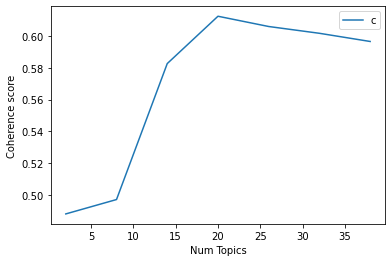

In [19]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4879
Num Topics = 8  has Coherence Value of 0.497
Num Topics = 14  has Coherence Value of 0.5827
Num Topics = 20  has Coherence Value of 0.6126
Num Topics = 26  has Coherence Value of 0.6061
Num Topics = 32  has Coherence Value of 0.6018
Num Topics = 38  has Coherence Value of 0.5967


In [21]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.036*"key" + 0.016*"system" + 0.013*"encryption" + 0.011*"bit" + '
  '0.010*"government" + 0.010*"chip" + 0.010*"technology" + 0.010*"security" + '
  '0.009*"public" + 0.009*"phone"'),
 (1,
  '0.019*"question" + 0.014*"exist" + 0.014*"true" + 0.013*"reason" + '
  '0.013*"claim" + 0.011*"point" + 0.011*"argument" + 0.009*"evidence" + '
  '0.009*"science" + 0.009*"answer"'),
 (2,
  '0.024*"space" + 0.009*"system" + 0.009*"year" + 0.008*"launch" + '
  '0.008*"project" + 0.008*"earth" + 0.007*"cost" + 0.007*"datum" + '
  '0.006*"satellite" + 0.006*"research"'),
 (3,
  '0.020*"gun" + 0.017*"state" + 0.014*"law" + 0.012*"people" + '
  '0.011*"government" + 0.009*"make" + 0.007*"crime" + 0.007*"weapon" + '
  '0.006*"year" + 0.006*"firearm"'),
 (4,
  '0.082*"write" + 0.068*"article" + 0.066*"line" + 0.042*"organization" + '
  '0.016*"bike" + 0.011*"ride" + 0.007*"reply" + 0.007*"nntp_poste" + '
  '0.006*"motorcycle" + 0.006*"opinion"'),
 (5,
  '0.032*"mail" + 0.027*"post" + 0.022*"sen

In [22]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,12.0,0.1854,"car, buy, price, sale, sell, good, pay, drive,...",From: (wheres my thing) Subject: WHAT car is t...
1,1,7.0,0.2056,"drive, card, problem, system, driver, bit, scs...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,18.0,0.1741,"time, make, good, thing, ve, give, bad, lot, p...",From: (Thomas E Willis) Subject: PB questions....
3,3,11.0,0.0982,"line, nntp_poste, organization, host, write, a...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,14.0,0.1810,"file, line, program, read, number, set, follow...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,3.0,0.3611,"gun, state, law, people, government, make, cri...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,5.0,0.1118,"mail, post, send, information, list, group, in...",From: (brian manning delaney) Subject: Brain T...
7,7,7.0,0.5156,"drive, card, problem, system, driver, bit, scs...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,10.0,0.1410,"window, file, image, version, program, display...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,7.0,0.2741,"drive, card, problem, system, driver, bit, scs...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [23]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9006,"key, system, encryption, bit, government, chip...",From: (Clipper Chip Announcement) Subject: tex...
1,1.0,0.7221,"question, exist, true, reason, claim, point, a...",From: (Petri Pihko) Subject: Re: Atheists view...
2,2.0,0.7947,"space, system, year, launch, project, earth, c...",From: (Jon Leech) Subject: Space FAQ 11/15 - U...
3,3.0,0.7435,"gun, state, law, people, government, make, cri...",From: (Larry Cipriani) Subject: Gun Talk -- St...
4,4.0,0.4933,"write, article, line, organization, bike, ride...",From: (Ed Green - Pixel Cruncher) Subject: Re:...


In [24]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,12.0,"car, buy, price, sale, sell, good, pay, drive,...",511.0,0.0452
1.0,7.0,"drive, card, problem, system, driver, bit, scs...",385.0,0.0340
2.0,18.0,"time, make, good, thing, ve, give, bad, lot, p...",510.0,0.0451
3.0,11.0,"line, nntp_poste, organization, host, write, a...",578.0,0.0511
4.0,14.0,"file, line, program, read, number, set, follow...",637.0,0.0563
...,...,...,...,...
11309.0,17.0,"drug, study, food, problem, doctor, effect, pa...",NaN,NaN
11310.0,7.0,"drive, card, problem, system, driver, bit, scs...",NaN,NaN
11311.0,7.0,"drive, card, problem, system, driver, bit, scs...",NaN,NaN
11312.0,11.0,"line, nntp_poste, organization, host, write, a...",NaN,NaN
